In [1]:
import operator
from functools import reduce
from itertools import repeat, cycle
import datetime
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection, LineCollection
from matplotlib import colors as mcolors

from vixstructure.data import TermStructure, Expirations

In [2]:
mpl.rcParams["figure.figsize"] = 16, 9

In [3]:
# Consider value '0' as NaN.
xm_settle = pd.read_csv("data/8_m_settle.csv", usecols=range(1,10), dtype=np.float32,
                        parse_dates=[0], header=0, index_col=0, na_values=0)
xm_symbols = pd.read_csv("data/8_m_symbols.csv", usecols=range(1,10), parse_dates=[0],
                         header=0, index_col=0, na_values=0)
expiration_months = pd.read_csv("data/expiration.months.csv", header=0, usecols=range(1,13), dtype=np.float32)
vix_index = pd.read_csv("data/vix.csv", parse_dates=[0], header=0, index_col=0, na_values="null",
                        dtype=np.float32)
expirations = pd.read_csv("data/expirations.csv", parse_dates=list(range(0,9)), usecols=range(1,10),
                                header=0, index_col=0)

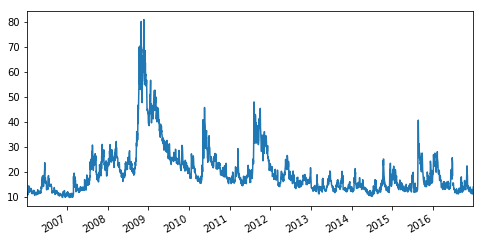

In [9]:
vix_index["Adj Close"]["2006":"2016"].plot(figsize=(8,4))
plt.xlabel("")
plt.savefig("vix.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

## Plot all the term structures in some large range
Helpful to get a general feeling.

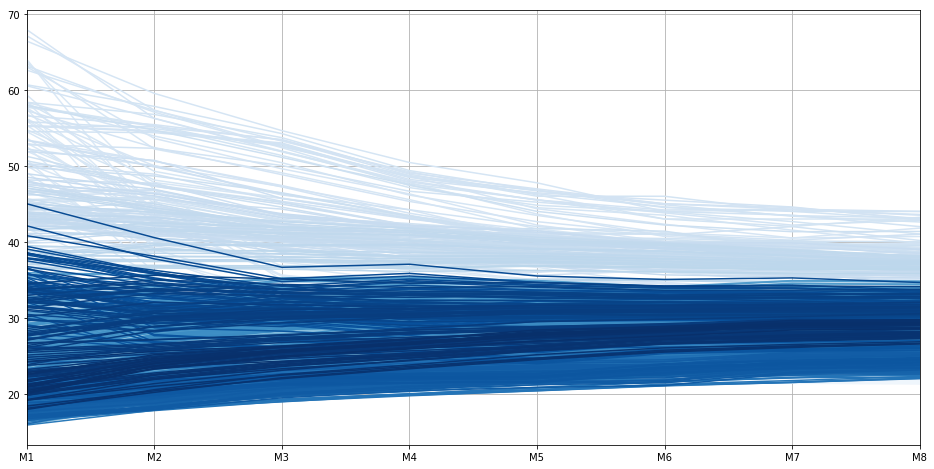

In [8]:
# Plot part of the data.
lines = xm_settle.iloc[1000:2000].T
lines.fillna(method='pad').plot(legend=False, figsize=(16,8), colormap=cm.Blues)
plt.grid()
plt.show()

## And this is a single term structure
One of the nice and clean ones.

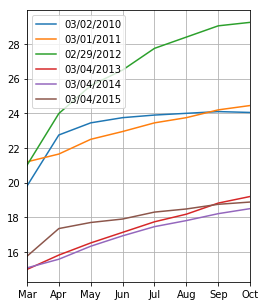

In [139]:
data_line = xm_settle.iloc[1240:3000:252].iloc[1:]
data_line.T.plot(style="-", legend=False, figsize=(4,5))
plt.grid()
plt.xticks(np.arange(8), calendar.month_abbr[3:])
plt.legend(tuple(map(lambda x: x.strftime("%m/%d/%Y"), data_line.index.date)), title=False)
plt.savefig("term-structure.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

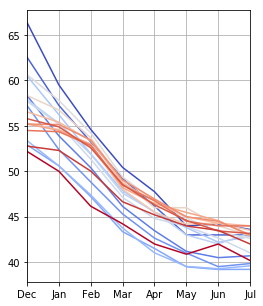

In [13]:
data_line = xm_settle.loc["2008-11-20":"2008-12-17"]
data_line.T.plot(style="-", legend=False, figsize=(4,5), colormap=cm.coolwarm)
plt.grid()
plt.xticks(np.arange(8), calendar.month_abbr[12:] + calendar.month_abbr[1:8])
plt.savefig("term-structure-crisis.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

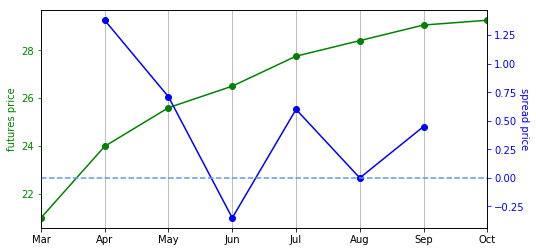

In [135]:
data_line = xm_settle.loc["2012-02-29"]
ax1 = data_line.T.plot(style="-o", legend=False, figsize=(8,4), color="green")
ax1.set_ylabel("futures price", color="green")
plt.xticks(np.arange(8), calendar.month_abbr[3:11])
ax1.tick_params(axis='y', colors='green')
data_line_spread = data_line.aggregate(
    lambda x: pd.Series([np.nan] + [2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x)-1)] + [np.nan],
                        index=calendar.month_abbr[3:11]))
ax2 = data_line_spread.plot(secondary_y=True, color="blue", style="-o")
ax2.set_ylabel("spread price", rotation=270, color="blue")
ax2.tick_params(axis='y', colors='blue')
ax1.grid(axis="x")
plt.axhline(0, color="CornflowerBlue", linestyle="--")
plt.savefig("long_spread.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

## Here I plot the contangos for a large range
Notice how the fluctuation of the M2-M1 contango is the largest while it steadily decreases for later expiration months.

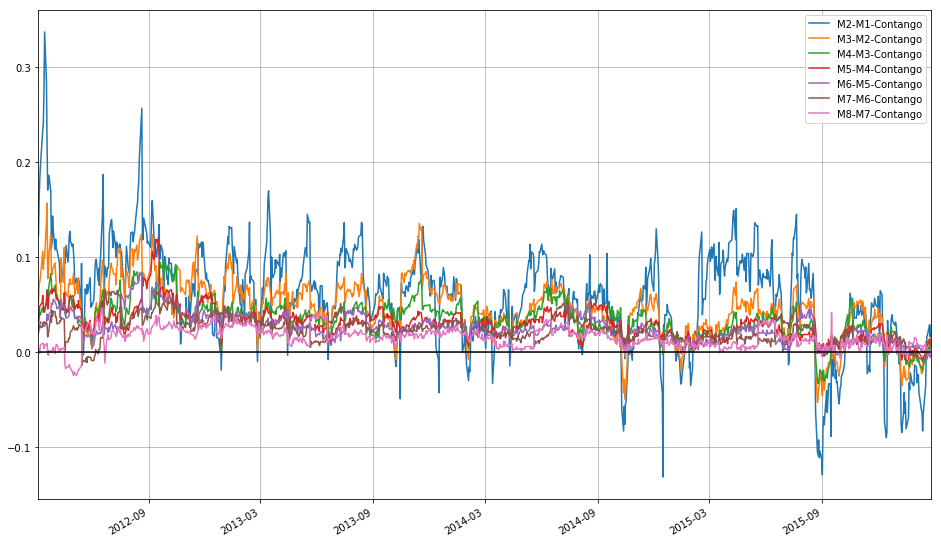

In [6]:
mxs = [xm_settle.iloc[2000:3000, i] for i in range(8)]
contangos = [(mxs[i + 1] - mxs[i]) / mxs[i] for i in range(8 - 1)]
contango_labels = ["M{}-M{}-Contango".format(i+1, i) for i in range(1,8)]
plt.figure(figsize=(16,10))
for i in range(len(contangos)):
    contangos[i].plot(label=contango_labels[i], legend=True)
plt.axhline(0, color="black")
plt.xlabel("")
plt.grid()
plt.show()

In [7]:
vix = vix_index["Adj Close"]   # Only this one is needed for the index.
trainingdata = pd.merge(pd.DataFrame(vix), xm_settle, left_index=True, right_index=True)

## Experimenting with data normalization

The make sure the training error isn't exploding it's best to normalize the data so its in (-1,1)-range. Doing this as simple as possible is preferred. Too much data wrangling beforehand might introduce some unwanted prior. Wenn normalizing the data all NaN values (including 0) aren't considered because they stand for not available data and influence the result too much.

In [8]:
mean = trainingdata.mean()
ptp = trainingdata.max() - trainingdata.min()
normalized = (trainingdata - mean) / ptp

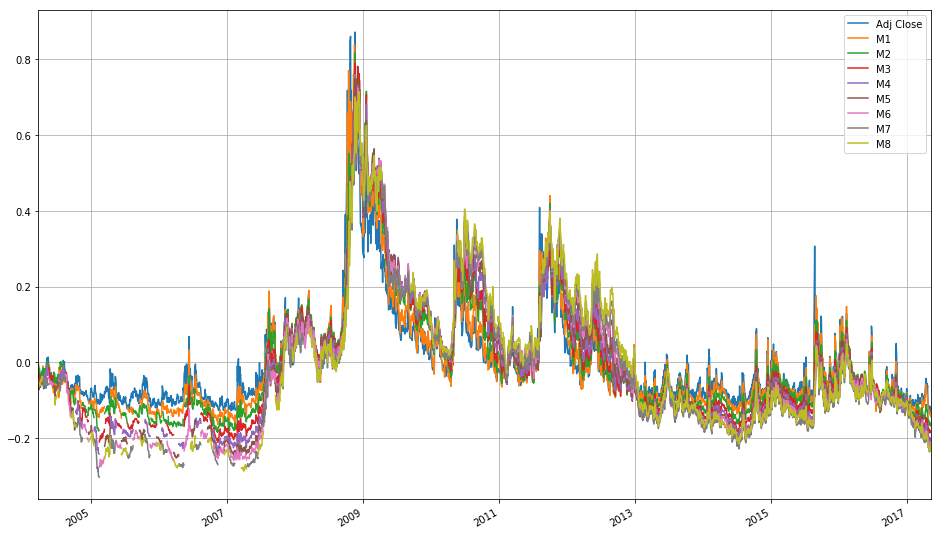

In [9]:
normalized.plot(figsize=(16,10))
plt.grid()
plt.show()

## Mapping Data to anual structure

At the moment you have a x-axis [M1,...,M8] but I want it [Jan,Feb,...,Dec]. All the points without given values are NaN. Something like expiration_months but with dates.

In [10]:
# Create a new data frame (not very efficient)
xm_year = pd.DataFrame(index=xm_settle.index, columns=expiration_months.columns, dtype=np.float32)
def symbol_to_month(symbol):
    mapping_dict = {"F":"January", "G":"February", "H":"March", "J":"April", "K":"May", "M":"June",
                    "N":"July", "Q":"August", "U":"September", "V":"October", "X":"November", "Z":"December"}
    return mapping_dict[symbol[0]]
for date, data in xm_year.iterrows():
    symbol = xm_symbols.loc[date].dropna().map(symbol_to_month)
    settle = xm_settle[symbol.index].loc[date]
    data[symbol] = settle

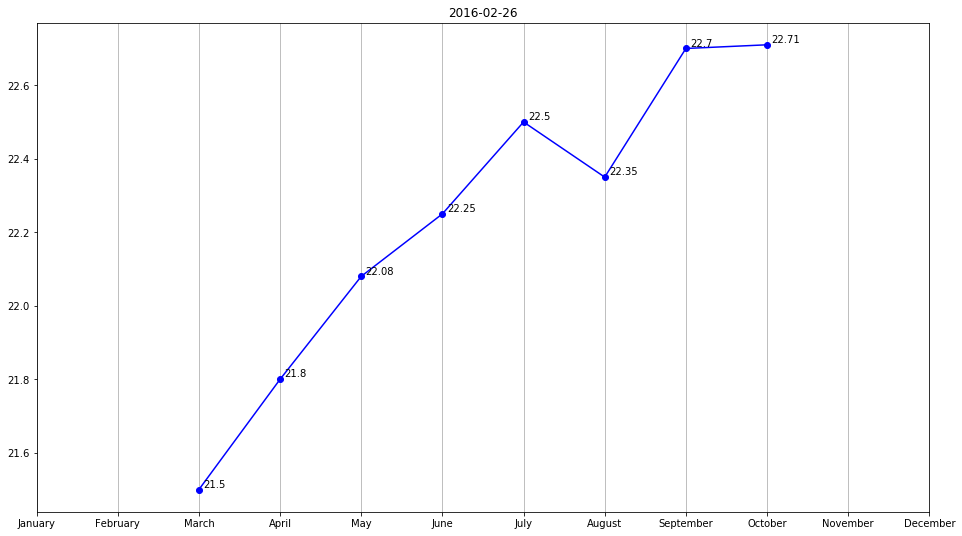

In [11]:
def plot_xm_year(index, scale=None, save=False):
    global xm_year
    month_to_x = {month:idx for idx, month in enumerate(xm_year.columns)}
    data = xm_year.iloc[index].dropna()
    x = data.rename(month_to_x).index.values
    y = data.values
    global xm_symbols
    months = xm_symbols.iloc[index].dropna().map(symbol_to_month).map(month_to_x)
    months_increasing = all(months[i] < months[i+1] for i in range(len(months) - 1))
    plt.figure(figsize=(16,9))
    if months_increasing:
        plt.plot(x, y, "-ob")
    else:
        splitindex = len(months) - months.values.argmin()
        plt.plot(x[:splitindex], y[:splitindex], "-ob")
        plt.plot(x[splitindex:], y[splitindex:], "-ob")
    plt.xticks(np.arange(12), xm_year.columns)
    if scale:
        y_min = xm_year.min().min()
        y_max = xm_year.max().max()
        plt.ylim(y_min, y_max)
    plt.xlim(0, 11)
    ydiff = plt.ylim()[1] - plt.ylim()[0]
    xdiff = plt.xlim()[1] - plt.xlim()[0]
    for idx, idy in zip(x, y):
        plt.text(idx + xdiff/200, idy + ydiff/200, idy)
    plt.grid(axis="x")
    plt.title(xm_year.iloc[index].name.date())
    if save:
        plt.savefig("img_annual_structure/{:04d}.png".format(index))
        plt.close()
    else:
        plt.show()
plot_xm_year(3000)

In [12]:
# Create a new data frame for spread prices
long_prices = pd.DataFrame(index=xm_year.index, columns=xm_year.columns, dtype=np.float32)
for date, data in xm_year.iterrows():
    data = np.concatenate((data[0:1], data, data[-1:]))
    # Calculate long prices (buy 2-1-1)
    prices = [2*data[i] - data[i-1] - data[i+1] for i in range(1,13)]
    long_prices.loc[date] = prices

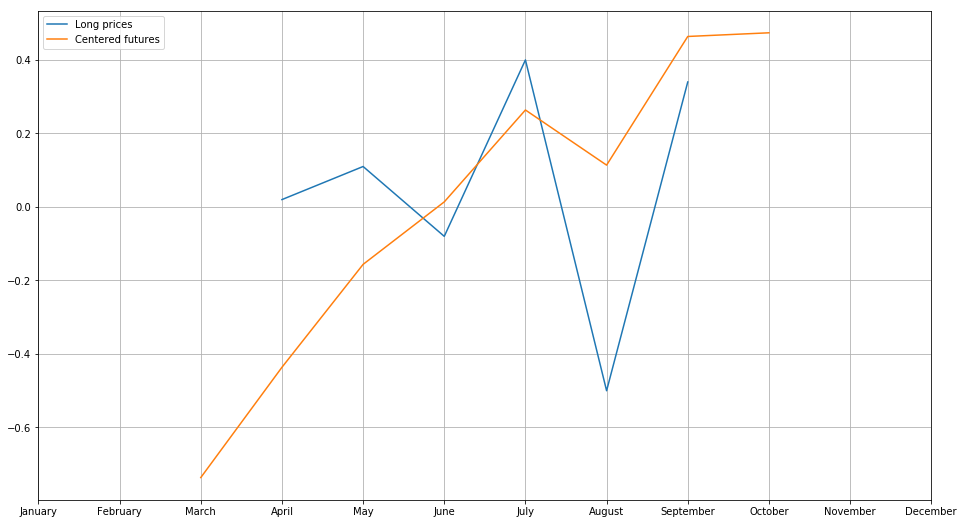

In [13]:
index = 3000
long_prices.iloc[index].plot(figsize=(16,9))
(xm_year.iloc[index] - xm_year.iloc[index].mean()).plot()
plt.grid()
plt.xticks(np.arange(12), long_prices.columns)
plt.legend(("Long prices", "Centered futures"), loc="upper left")
plt.show()

## What to do with NaN values?

There is a high number of NaN values especially with early data. It is the best to remove this first part because it is simply to unstable.

In [14]:
# There are times when no spread prices can be calculated.
long_prices.dropna(how="all").shape

(2887, 12)

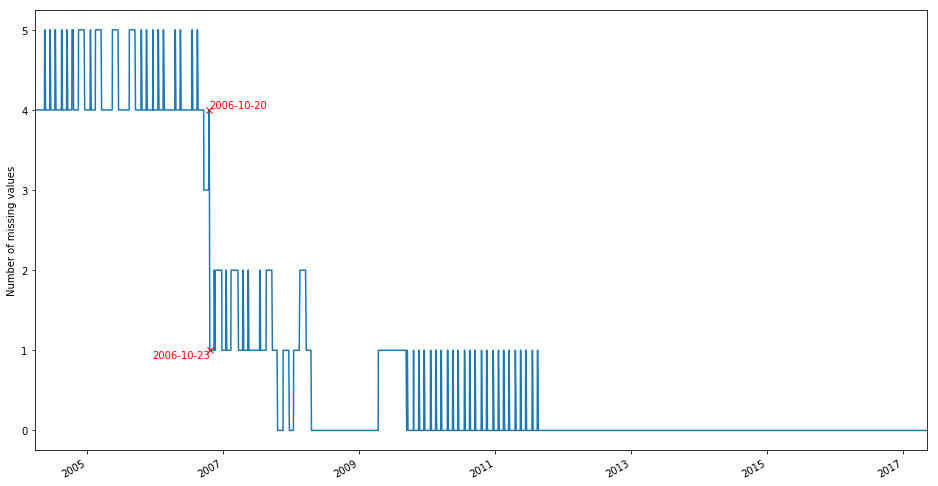

In [42]:
def plot_one_date(data_point, ha="left", va="bottom"):
    plt.plot(data_point.name, data_point.isnull().sum(), 'rx')
    plt.text(data_point.name, data_point.isnull().sum(), data_point.name.date(), ha=ha, va=va, color="r")
xs_null = xm_settle.isnull().sum(axis=1)
xs_null.plot()
plt.ylabel("Number of missing values")
plt.xlabel("")
count_nan = xm_settle.isnull().sum(axis=1)
last_day_with_many_nans = count_nan[count_nan > 2].index[-1]
first_day_with_usable_data = xm_settle.loc[last_day_with_many_nans:].iloc[1]
plot_one_date(first_day_with_usable_data, "right", "top")
plot_one_date(xm_settle.loc[last_day_with_many_nans])
plt.show()

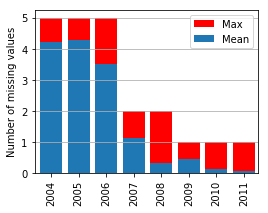

In [152]:
xs_null = xs_null[xs_null > 0]
xs_null.groupby(xs_null.index.year).max().plot.bar(figsize=(4,3), color="r", width=0.8)
xs_full = xm_settle.isnull().sum(axis=1)
xs_full.groupby(xs_full.index.year).mean().plot.bar(stacked=True, width=0.8)
plt.xlim(-0.6,7.5)
plt.legend(("Max", "Mean"))
plt.xlabel("")
plt.ylabel("Number of missing values")
plt.grid(axis="y")
plt.savefig("missing_values.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [16]:
clip_settle = xm_settle.loc[last_day_with_many_nans + datetime.timedelta(days=1):]
clip_year = xm_year.loc[last_day_with_many_nans + datetime.timedelta(days=1):]
assert clip_settle.index.identical(clip_year.index)
print("These are the data points you can actually use:")
len(clip_settle)

These are the data points you can actually use:


2656

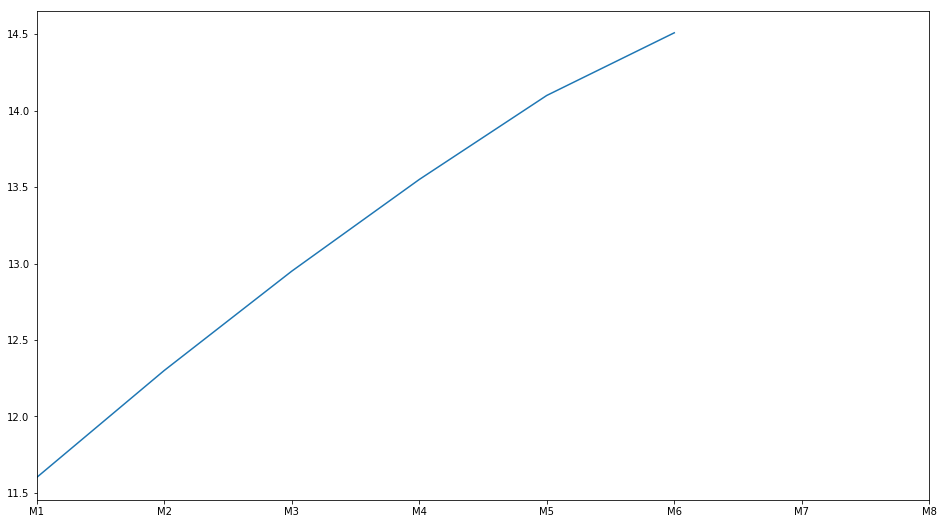

In [17]:
clip_settle.loc["2006-11-15"].plot(figsize=(16,9))
plt.show()

In [18]:
clip_settle.isnull().sum()

M1      0
M2      0
M3      0
M4      0
M5      0
M6     27
M7    186
M8    408
dtype: int64

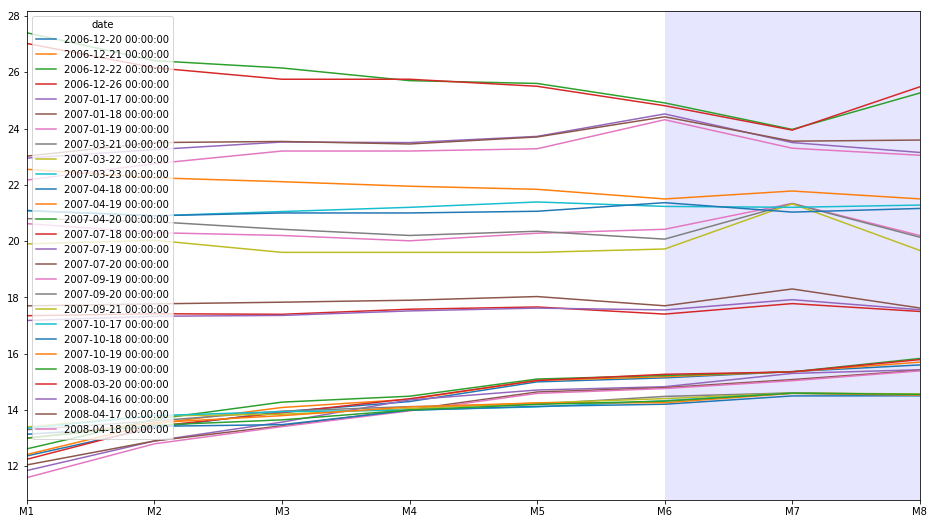

In [19]:
clip_settle.interpolate()[clip_settle.isnull()["M6"] == True].T.plot(figsize=(16,9))
plt.axvspan(5, 8, color=(0.9,0.9,1))
plt.show()

## How large are the gaps in the data from holidays, weekends etc.?

- A gap of one day is normal
- A gap of two days means a weekend (and that is essentially every fifth day)

In [106]:
dates = pd.Series(xm_settle.index)

In [107]:
dates_diff = dates.diff()
dates_diff.groupby(dates_diff).count()

date
1 days    2591
2 days      27
3 days     593
4 days      90
5 days       2
Name: date, dtype: int64

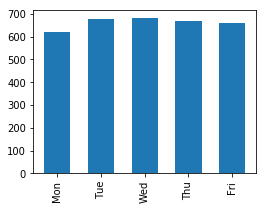

In [123]:
weekdays = dates.map(operator.methodcaller("weekday"))
name_of_weekday = tuple(calendar.day_abbr)
weekdays = weekdays.groupby(weekdays).count()
weekdays.index = weekdays.index.map(lambda x: name_of_weekday[x])
weekdays.plot.bar(figsize=(4,3), width=0.6)
plt.xlabel("")
plt.savefig("weekdays.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# Finding the right input data

Note that only data from 2006-10-23 is used (look above).

In [23]:
expirations = expirations.loc["2006-10-23":]
xm_settle = xm_settle.loc["2006-10-23":]
assert expirations.shape == xm_settle.shape

## 1. Time to expiration

In [24]:
expirations_v1 = expirations["V1"]

In [25]:
until_expiration = pd.Series(expirations_v1.values - expirations_v1.index.values)
assert len(until_expiration) == len(expirations)
until_expiration.index = expirations.index
until_expiration.name = "Expiration"

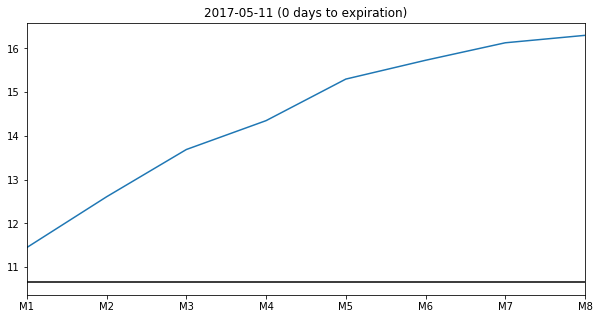

In [26]:
xm_settle.iloc[-1].plot(figsize=(10,5))
plt.axhline(vix[-1], color="black")
date = xm_settle.iloc[-1].name
plt.title("{} ({} days to expiration)".format(date.date(), until_expiration.loc[date].days))
plt.show()

## 2. Difference between term structure legs

This is the input data.

In [27]:
settle_diff = xm_settle.diff(axis=1).iloc[:,1:] # Because first column only has NaNs
settle_diff = settle_diff.join(xm_settle.iloc[:,0]) # Get original first value in
settle_diff = settle_diff.iloc[:,range(-1,7)] # Get the order right: M1 -> M8
settle_diff

,M1,M2,M3,M4,M5,M6,M7,M8
date,,,,,,,,
2006-10-23,11.900000,1.250000,0.930000,0.570000,0.380000,0.500000,0.170000,NaN
2006-10-24,11.770000,1.040000,1.250000,0.440000,0.660000,0.250000,0.190001,NaN
2006-10-25,11.490000,1.030001,1.219999,0.730000,0.450000,0.510000,0.170000,NaN
2006-10-26,11.270000,0.950000,1.280000,0.660000,0.800000,0.290000,0.190000,NaN
2006-10-27,11.350000,0.900000,1.240000,0.740000,0.760000,0.200000,0.260000,NaN
2006-10-30,11.300000,0.970000,1.080000,0.799999,0.510000,0.440001,0.365000,NaN
2006-10-31,11.350000,0.799999,1.050000,0.750000,0.660000,0.370000,0.270000,NaN
2006-11-01,11.510000,0.940000,0.790000,0.710000,0.540000,0.390000,0.200000,NaN
2006-11-02,11.660000,0.780000,0.720000,0.640000,0.710000,0.240000,0.300000,NaN


-21.1 67.9


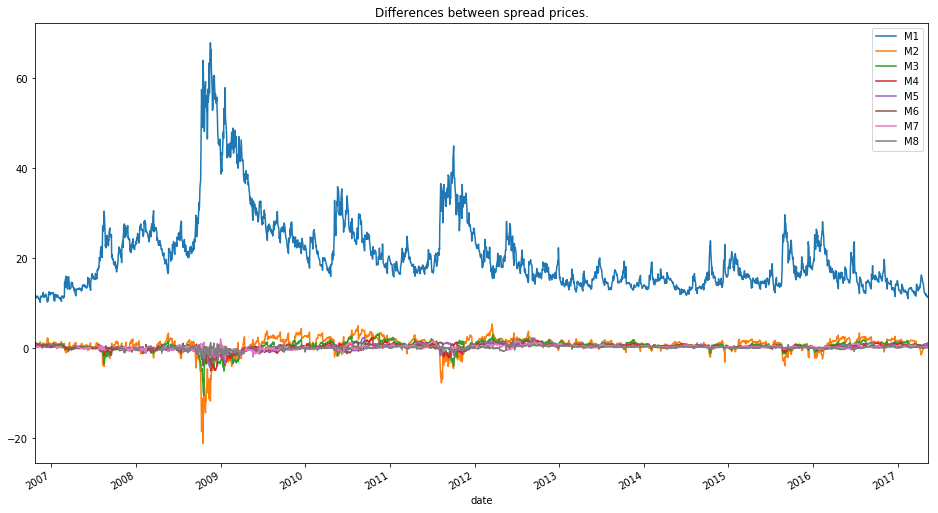

In [28]:
settle_diff.plot(figsize=(16,9))
print(settle_diff.min().min(), settle_diff.max().max())
plt.title("Differences between spread prices.")
plt.show()

## Get targets (spread prices)

In [29]:
expiration_indices = until_expiration.where(until_expiration == pd.Timedelta(0))
expiration_indices.index = range(len(expiration_indices))
expiration_indices = expiration_indices.dropna().index
expiration_indices

Int64Index([  17,   41,   57,   77,  101,  120,  140,  164,  183,  208,
            ...
            2471, 2495, 2515, 2535, 2559, 2576, 2596, 2620, 2640, 2655],
           dtype='int64', length=127)

In [30]:
# First consider the expired futures. One the next day they get value NaN.
spreads = xm_settle.copy()
spreads.iloc[expiration_indices[:-1] + 1] = xm_settle.iloc[expiration_indices[:-1] + 1].iloc[:,1:].assign(M1=lambda x: np.NaN).iloc[:,range(-1,7)]
assert len(spreads[spreads.M1.isnull() == True]) == len(expiration_indices) - 1
def calculate_long_prices(term: pd.Series):
    longs = [2*term[i] - term[i-1] - term[i+1] for i in range(1, len(term)-1)]
    return pd.Series(longs, term[1:-1].index)
spreads = spreads.apply(calculate_long_prices, axis=1)

In [31]:
xm_settle.shape

(2656, 8)

In [32]:
assert spreads.index.identical(settle_diff.index)

In [33]:
xm_settle7 = xm_settle.loc[:,"M1":"M7"]
xm_settle7_test = xm_settle7.loc["2006-11-15"].dropna()
xm_settle7_test

M1    11.60
M2    12.30
M3    12.95
M4    13.55
M5    14.10
M6    14.51
Name: 2006-11-15 00:00:00, dtype: float32

In [34]:
xm_settle7_test.index = list(range(len(xm_settle7_test.index)))

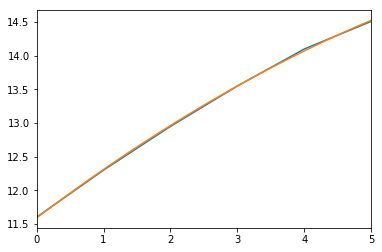

In [35]:
z = np.polyfit(xm_settle7_test.index, xm_settle7_test, 2)
p = np.poly1d(z)
xm_settle7_test.plot()
xp = np.linspace(0, 5, 100)
plt.plot(xp, p(xp))
plt.show()

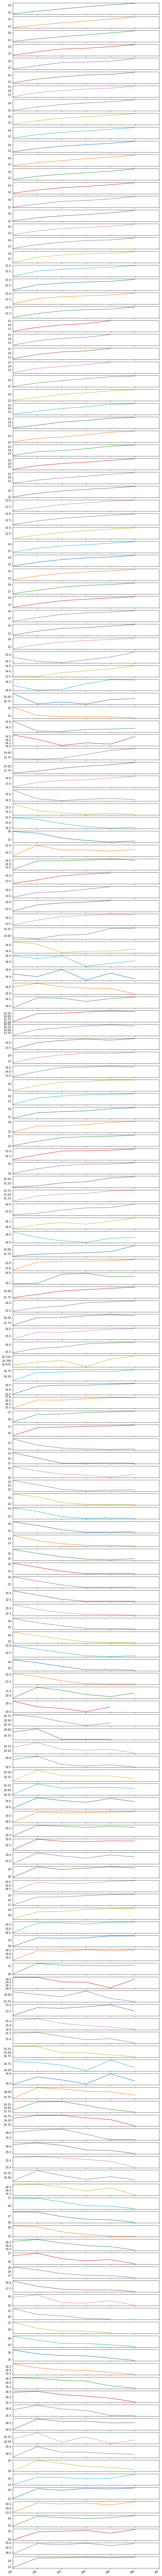

In [36]:
xm_settle7[xm_settle7.M7.isnull()].T.plot(figsize=(10,200), legend=False, subplots=True)
plt.show()

## Normalization

-0.79177435516 0.620398106199


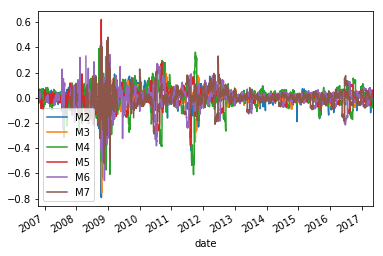

In [37]:
spreads_norm = (spreads - spreads.mean()) / (spreads.max() - spreads.min())
print(spreads_norm.min().min(), spreads_norm.max().max())
spreads_norm.plot()
plt.show()

-0.824046 0.817341


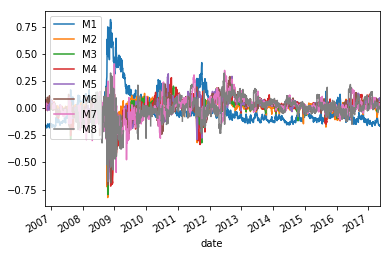

In [38]:
settle_norm = (settle_diff - settle_diff.mean()) / (settle_diff.max() - settle_diff.min())
print(settle_norm.min().min(), settle_norm.max().max())
settle_norm.plot()
plt.show()

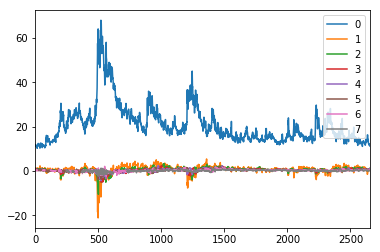

In [39]:
settle_denorm = settle_norm.values * (settle_diff.max() - settle_diff.min()).values + settle_diff.mean().values
pd.DataFrame(settle_denorm).plot()
plt.show()

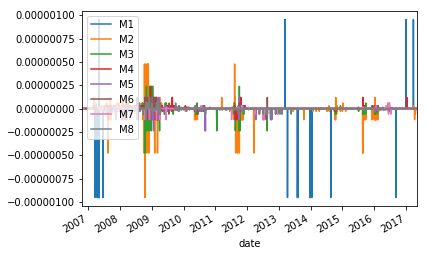

In [40]:
settle_test = (settle_diff - settle_denorm)
settle_test.plot()
plt.show()

## Splitting the data

We need a set for training, cross validation and testing.

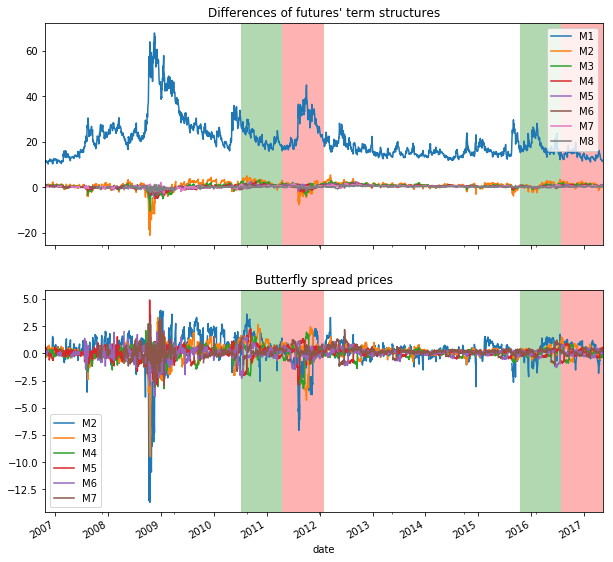

In [41]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10,10))
settle_diff.plot(ax=axes[0])
def plot_vlines(ax):
    l = len(settle_diff)
    s = int(l * 0.15 / 2)
    # Validation (red)
    ax.axvspan(settle_diff.index[int(l/2-s)], settle_diff.index[int(l / 2)], facecolor="r", alpha=0.3)
    ax.axvspan(settle_diff.index[-s], settle_diff.index[-1], facecolor="r", alpha=0.3)
    # Test (green)
    ax.axvspan(settle_diff.index[int(l/2-2*s)], settle_diff.index[int(l/2)-s], facecolor="g", alpha=0.3)
    ax.axvspan(settle_diff.index[-2*s], settle_diff.index[-s], facecolor="g", alpha=0.3)
plot_vlines(axes[0])
axes[0].set_title("Differences of futures' term structures")
spreads.plot(ax=axes[1])
plot_vlines(axes[1])
axes[1].set_title("Butterfly spread prices")
plt.show()

# Naive prediction

What is the loss when the network always the same as the current day? (identity)

In [42]:
expirations = Expirations("data/expirations.csv")
termStructure = TermStructure("data/8_m_settle.csv", expirations)

In [43]:
naive_prediction_error = termStructure.long_prices[:-1].values - termStructure.long_prices[1:].values

In [108]:
print("Naive MSE. I definitely have to beat this!")
print(np.nanmean(np.square(naive_prediction_error)))

Naive MSE. I definitely have to beat this!
0.170281337234


# Playing around with visualizations

In [7]:
xm_settle.dropna(how="all", axis=(0,1), inplace=True)
xm_settle.describe()

,M1,M2,M3,M4,M5,M6,M7,M8
count,3202.000000,3183.000000,2964.000000,2894.000000,2871.000000,2843.000000,2689.000000,2456.000000
mean,19.641655,20.498621,21.377987,21.867867,22.208729,22.492094,23.008997,22.812176
std,8.391534,7.528675,7.047597,6.611469,6.305173,6.080849,5.888752,5.630231
min,10.240000,11.700000,12.520000,12.790000,13.600000,13.530000,13.650000,14.300000
25%,14.222500,15.250000,16.299999,17.000000,17.520000,17.955000,18.580000,18.767500
50%,16.905000,18.299999,19.370001,20.214999,20.450001,20.900000,21.540001,20.930000
75%,22.587500,23.690001,24.600000,24.967499,25.415000,25.719999,26.510000,25.750000
max,67.900002,59.520000,54.619999,50.430000,47.759998,45.990002,44.580002,44.000000


In [8]:
xm_settle[xm_settle.isnull().sum(axis=1) >= 5]

,M1,M2,M3,M4,M5,M6,M7,M8
date,,,,,,,,
2004-05-19,19.170000,NaN,20.620001,NaN,NaN,21.180000,NaN,NaN
2004-05-20,19.280001,NaN,20.680000,NaN,NaN,21.129999,NaN,NaN
2004-05-21,19.100000,NaN,20.799999,NaN,NaN,21.100000,NaN,NaN
2004-06-16,17.150000,19.260000,NaN,NaN,20.090000,NaN,NaN,NaN
2004-06-17,17.150000,19.250000,NaN,NaN,20.049999,NaN,NaN,NaN
2004-06-18,16.940001,19.250000,NaN,NaN,20.000000,NaN,NaN,NaN
2004-07-14,18.809999,NaN,NaN,20.230000,NaN,NaN,20.549999,NaN
2004-07-15,18.700001,NaN,NaN,20.200001,NaN,NaN,20.510000,NaN
2004-07-16,18.900000,NaN,NaN,20.490000,NaN,NaN,20.629999,NaN


In [9]:
exp_last = expirations.loc[xm_settle.iloc[-1].name]
exp_last.index = xm_settle.iloc[-1].index
templol = pd.concat((xm_settle.iloc[-1], exp_last), axis=1).T
templol.index = ["Value", "Expiration"]
templol.loc["Expiration"] = templol.loc["Expiration"].apply(lambda x: x.strftime("%b %d"))
print(templol.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &      M1 &      M2 &      M3 &      M4 &      M5 &      M6 &      M7 &      M8 \\
\midrule
Value      &   11.45 &   12.61 &   13.69 &   14.35 &    15.3 &   15.73 &   16.13 &    16.3 \\
Expiration &  May 11 &  May 18 &  Jun 15 &  Jul 19 &  Aug 16 &  Sep 20 &  Oct 18 &  Nov 15 \\
\bottomrule
\end{tabular}



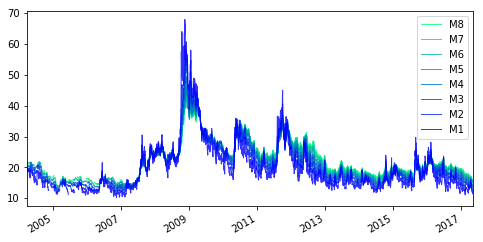

In [28]:
xm_settle.iloc[::, ::-1].plot(colormap=cm.winter_r, figsize=(8,4), linewidth=1.0, alpha=0.8)
plt.xlabel("")
plt.savefig("termstructures.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

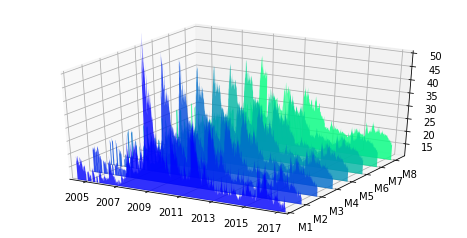

In [148]:
fig = plt.figure(figsize=(8, 4))
ax = fig.gca(projection='3d')
xs = np.arange(len(xm_settle))
zs = np.arange(0, 8)
verts = []
xm_settle_3dplot = xm_settle.copy()
xm_settle_3dplot.index = xs
for z in zs:
    ys = xm_settle_3dplot.iloc[:,int(z)].fillna(10)
    ys.iloc[0] = 10
    ys.iloc[-1] = 10
    verts.append(list(zip(ys.index.values, ys.values)))
poly = PolyCollection(verts, linewidth=2.0, facecolors=[cm.winter(i, 0.8) for i in  np.linspace(0, 1, 8)])
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlim3d(0, len(xm_settle))
ax.set_xticks([(xm_settle.index.year == year).argmax() for year in xm_settle.index.year.unique()[1::2]])
ax.set_xticklabels(xm_settle.index.year.unique()[1::2])
ax.set_ylim3d(0.0, 7.5)
ax.set_yticklabels(["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"])
ax.set_zlim3d(11, 50)

plt.savefig("termstructures.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

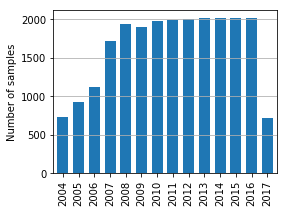

In [141]:
xm_settle.groupby(xm_settle.index.year).count().sum(axis=1).plot.bar(figsize=(4,3), width=0.7)
plt.xlabel("")
plt.ylabel("Number of samples")
plt.grid(axis="y")
plt.savefig("number_of_samples.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()